# Fairness Checking: Linear Program (Equalized Odds) w/ Different Models
This notebook solves the EO Linear Program with the results from the 40 different models (20 models with varying depths, 20 models with varying hidden units) in compas_nn_risk_score_diffmodel.ipynb.

In [0]:
!pip install pulp

     |████████████████████████████████| 13.6MB 2.9MB/s 
  Created wheel for pulp: filename=PuLP-1.6.10-cp36-none-any.whl size=12269903 sha256=1db347d4e6fc6e93a7e12ab00a877542b191f57469be526edad905817eecae69
  Stored in directory: /root/.cache/pip/wheels/5e/76/77/e28b22219e46e3b4b033f02e8b36b2770ae545bdcf60c2b224
Successfully built pulp


In [0]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
NUMBER_OF_MODELS = 20

# Case 1: Depth NNs
We have 100 different models with varying depths. diffmodel_0 has the shallowest depth (1 layer), and diffmodel_99 has the deepest depth (100 layers).


## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

Import for each of the f(X)'s. Call them f_1(X), f_2(X), ... f_100(X).


In [0]:
df = []
for i in range(NUMBER_OF_MODELS):
  df.append(pd.read_csv('/content/drive/My Drive/colab/fairness_checking/depth_models/diffmodel_{}.csv'.format(i)))

In [0]:
# Sanity Check: make sure we have different f(X)'s
df[0].head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.052690,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.829273,1
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.172630,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.126032,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.632580,1


In [0]:
# Sanity Check: make sure we have different f(X)'s
df[NUMBER_OF_MODELS - 1].head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.44713,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.44713,0
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.44713,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.44713,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.44713,0


In [0]:
# Our protected variable A is race, and a = 0 or a = 1. Doesn't matter which DF
# we get this from because they are all in the same order.
a = df[0]['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [0]:
# Our true label Y is risk_recid, and y = 0 or y = 1. Doesn't matter which DF
# we get this from because they are all in the same order.
y = df[0]['risk_recid']
np.asarray(y)
y_0_indices = []
y_1_indices = []

for i in range(len(y)):
    if y[i] == 0:
        y_0_indices.append(i)
    elif y[i] == 1:
        y_1_indices.append(i)

In [0]:
# Find the intersection of indices lists to make the pi's
a_0 = set(a_0_indices)
a_1 = set(a_1_indices)
y_0 = set(y_0_indices)
y_1 = set(y_1_indices)

a0_y0 = a_0.intersection(y_0) 
a0_y1 = a_0.intersection(y_1)
a1_y0 = a_1.intersection(y_0)
a1_y1 = a_1.intersection(y_1)

In [0]:
# Sanity check
print(len(a_0))
print(len(a0_y1) + len(a0_y0))
print(len(a_1))
print(len(a1_y1) + len(a1_y0))

609
609
623
623


In [0]:
# Our pi variables, pi_a_y are simply the proportions where we have A = a, Y = y
pi_0_0 = float(len(a0_y0))/(len(a_0_indices) + len(a_1_indices))
pi_0_1 = float(len(a0_y1))/(len(a_0_indices) + len(a_1_indices))
pi_1_0 = float(len(a1_y0))/(len(a_0_indices) + len(a_1_indices))
pi_1_1 = float(len(a1_y1))/(len(a_0_indices) + len(a_1_indices))

In [0]:
print(pi_0_0)
print(pi_0_1)
print(pi_1_0)
print(pi_1_1)

0.35064935064935066
0.14366883116883117
0.20454545454545456
0.30113636363636365


In [0]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = []
for i in range(len(df)):
  f_X.append(df[i]['prediction_probs'])
  np.asarray(f_X[i])

In [0]:
# Check if the dimensions match
print(len(f_X[0]))
print(len(f_X[1]))
print(len(f_X[2]))
print(len(f_X[18]))
print(len(f_X[19]))
print(len(a0_y1) + len(a0_y0) + len(a1_y1) + len(a1_y0))

1232
1232
1232
1232
1232
1232


## Linear Program Function
Create a reusable function for each linear program.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [0]:
# Input: function f(X), y_value (either 0 or 1)
# Output: (solved) model, weights
def EO_linear_prog(f_X, y_value):
  if(y_value != 0 and y_value != 1):
    return("Please enter 0 or 1 for the second argument (y_value).")
  
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Equalized Odds Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  if(y_value == 0):
    # Objective Function
    model += pulp.lpSum(
      [(1./pi_0_0) * w[index] * f_X[index] for index in a0_y0] +
      [- (1./pi_1_0) * w[index] * f_X[index] for index in a1_y0])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 0}) = pi_0_0
    model += pulp.lpSum([w[index] for index in a0_y0]) == pi_0_0
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y0]) == pi_1_0
    
  elif(y_value == 1):
    # Objective Function
    model += pulp.lpSum(
        [(1./pi_0_1) * w[index] * f_X[index] for index in a0_y1] +
        [- (1./pi_1_1) * w[index] * f_X[index] for index in a1_y1])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a0_y1]) == pi_0_1
    
    # Constraint that the \sum(w_i * 1{a = 1, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y1]) == pi_1_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1
  
  # Solve the linear program
  model.solve()
  
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[w[i]] = w[i].varValue

## Solve Linear Programs (Y = 0)
We use the PuLP package to solve the linear program for each of the f(X), where Y = 0.

In [0]:
# Solve for each of the f(X)
y0_models = []
y0_weights = []

for i in range(len(f_X)):
  model, weights = EO_linear_prog(f_X[i], 0)
  y0_models.append(model)
  y0_weights.append(weights)

In [0]:
# Get all the objective values
for i in range(len(f_X)):
  result_string = "Objective for f(X)_{} where Y = 0: ".format(i)
  print(result_string + str(pulp.value(y0_models[i].objective)))

Objective for f(X)_0 where Y = 0: 0.8289112788097064
Objective for f(X)_1 where Y = 0: 0.8342798890566627
Objective for f(X)_2 where Y = 0: 0.8992440236786192
Objective for f(X)_3 where Y = 0: 0.8930473586816015
Objective for f(X)_4 where Y = 0: 0.8797639016441753
Objective for f(X)_5 where Y = 0: 0.9058415989652272
Objective for f(X)_6 where Y = 0: 0.8215438889792102
Objective for f(X)_7 where Y = 0: 0.7965660990771836
Objective for f(X)_8 where Y = 0: 0.7845707621015225
Objective for f(X)_9 where Y = 0: 0.865071113925028
Objective for f(X)_10 where Y = 0: 0.9338238844480405
Objective for f(X)_11 where Y = 0: 0.882632728900295
Objective for f(X)_12 where Y = 0: 0.8260997370010469
Objective for f(X)_13 where Y = 0: 0.8673152625498229
Objective for f(X)_14 where Y = 0: 0.8149761867980722
Objective for f(X)_15 where Y = 0: 0.7303597943363721
Objective for f(X)_16 where Y = 0: 0.8537689765696279
Objective for f(X)_17 where Y = 0: 9.10132774700756e-09
Objective for f(X)_18 where Y = 0: 0.8

Text(0.5, 1.0, 'NN Depth vs. EO LP Objective Value (Y=0)')

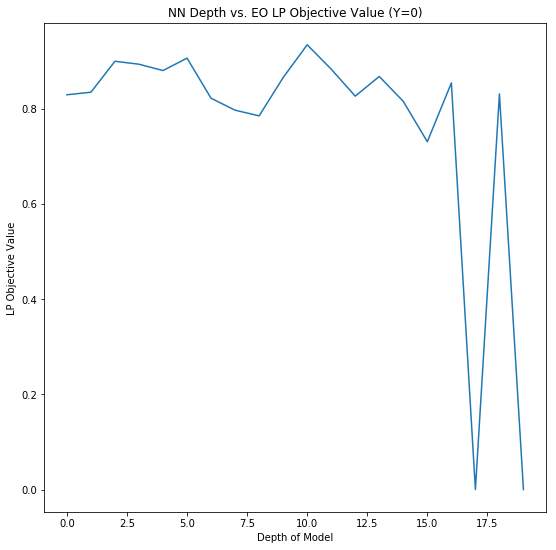

In [0]:
# Plot objective values
y0_objectives = []
for i in range(len(y0_models)):
  y0_objectives.append(pulp.value(y0_models[i].objective))

plt.figure(figsize=(9,9))
plt.plot(y0_objectives)
# plt.axis([0, 20, 0.5, 1.0])
plt.xlabel('Depth of Model')
plt.ylabel('LP Objective Value')
plt.title('NN Depth vs. EO LP Objective Value (Y=0)')

Text(0.5, 1.0, 'NN Depth vs. Model Test Accuracy')

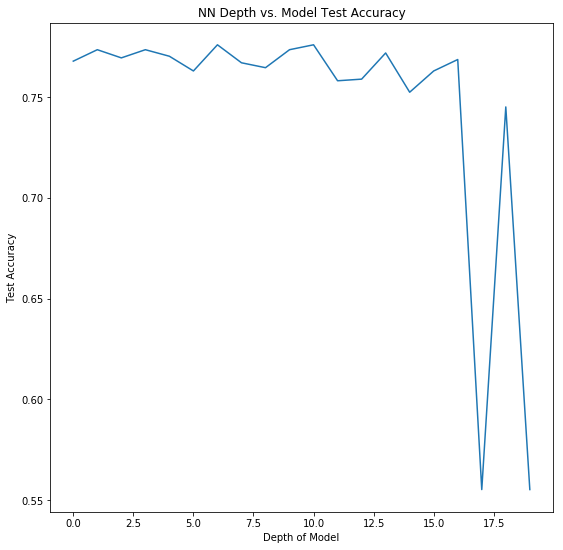

In [0]:
# Plot training accuracies over depth
depth_model_accuracies_df = pd.read_csv('/content/drive/My Drive/colab/fairness_checking/depth_models/depth_model_accuracies.csv')
depth_model_accuracies_df.head(5)
depth_model_acc = depth_model_accuracies_df['Model Accuracy']

plt.figure(figsize=(9,9))
plt.plot(depth_model_acc)
# plt.axis([0, 100, 0.8, 1.0])
plt.xlabel('Depth of Model')
plt.ylabel('Test Accuracy')
plt.title('NN Depth vs. Model Test Accuracy')

## Solve Linear Programs (Y = 1)
We use the PuLP package to solve the linear program for each of the f(X), where Y = 1.

In [0]:
# Solve for each of the f(X)
y1_models = []
y1_weights = []

for i in range(len(f_X)):
  model, weights = EO_linear_prog(f_X[i], 1)
  y1_models.append(model)
  y1_weights.append(weights)

In [0]:
# Get all the objective values
for i in range(len(f_X)):
  result_string = "Objective for f(X)_{} where Y = 1: ".format(i)
  print(result_string + str(pulp.value(y1_models[i].objective)))

Objective for f(X)_0 where Y = 1: 0.8771502833141724
Objective for f(X)_1 where Y = 1: 0.8723874883933457
Objective for f(X)_2 where Y = 1: 0.9166612568578667
Objective for f(X)_3 where Y = 1: 0.8864976132252422
Objective for f(X)_4 where Y = 1: 0.915989028872199
Objective for f(X)_5 where Y = 1: 0.8521742336464728
Objective for f(X)_6 where Y = 1: 0.901735367021358
Objective for f(X)_7 where Y = 1: 0.8686734234236317
Objective for f(X)_8 where Y = 1: 0.8979048030732812
Objective for f(X)_9 where Y = 1: 0.8901532491811208
Objective for f(X)_10 where Y = 1: 0.9000669030689178
Objective for f(X)_11 where Y = 1: 0.8812291232962802
Objective for f(X)_12 where Y = 1: 0.8178363439057847
Objective for f(X)_13 where Y = 1: 0.9247324127457968
Objective for f(X)_14 where Y = 1: 0.8072771738341682
Objective for f(X)_15 where Y = 1: 0.667619885075658
Objective for f(X)_16 where Y = 1: 0.9711035201910049
Objective for f(X)_17 where Y = 1: 1.760307899445479e-09
Objective for f(X)_18 where Y = 1: 0.9

Text(0.5, 1.0, 'NN Depth vs. EO LP Objective Value (Y=1)')

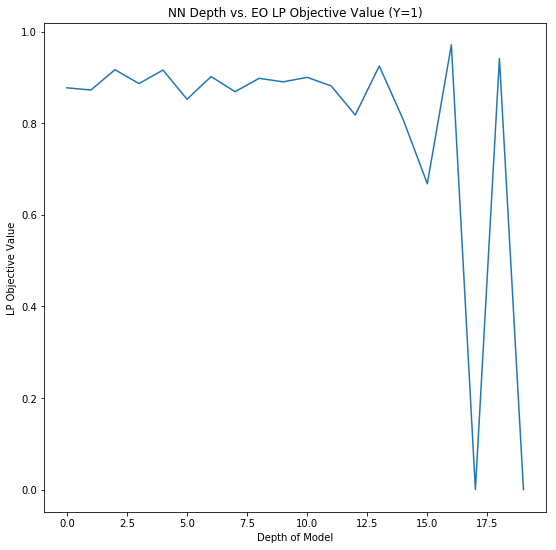

In [0]:
# Plot objective values
y1_objectives = []
for i in range(len(y1_models)):
  y1_objectives.append(pulp.value(y1_models[i].objective))

plt.figure(figsize=(9,9))
plt.plot(y1_objectives)
# plt.axis([0, 20, 0.8, 1.0])
plt.xlabel('Depth of Model')
plt.ylabel('LP Objective Value')
plt.title('NN Depth vs. EO LP Objective Value (Y=1)')

Text(0.5, 1.0, 'NN Depth vs. Model Test Accuracy')

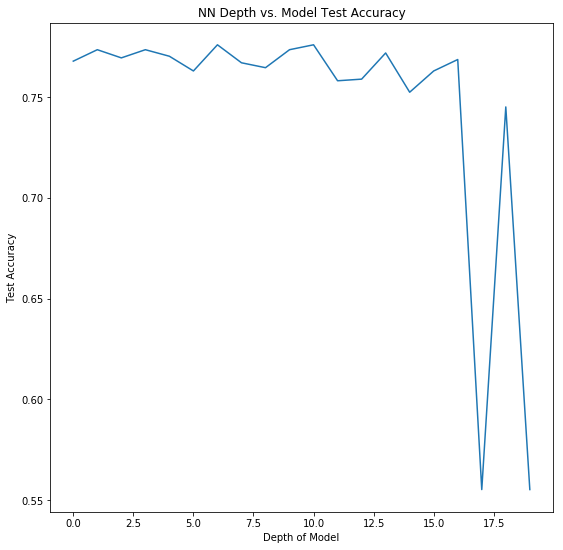

In [0]:
# Plot training accuracies over depth
depth_model_accuracies_df = pd.read_csv('/content/drive/My Drive/colab/fairness_checking/depth_models/depth_model_accuracies.csv')
depth_model_accuracies_df.head(5)
depth_model_acc = depth_model_accuracies_df['Model Accuracy']

plt.figure(figsize=(9,9))
plt.plot(depth_model_acc)
# plt.axis([0, 100, 0.8, 1.0])
plt.xlabel('Depth of Model')
plt.ylabel('Test Accuracy')
plt.title('NN Depth vs. Model Test Accuracy')

In [0]:
# Save as a CSV
df = pd.DataFrame({'Depth of Model (Layers)':range(1,NUMBER_OF_MODELS + 1), 'EO LP Objective Values (Y=0)':y0_objectives, 'EO LP Objective Values (Y=1)':y1_objectives})
df.head(5)
df.to_csv('/content/drive/My Drive/colab/fairness_checking/eo_depth_models.csv')

# Case 2: Hidden Unit NNs
We have 100 different models with varying hidden units. diffmodel_0 has the least hidden units (20 per layer), and diffmodel_99 has the most hidden units (2000 per layer). Each model has a constant 5 layers.

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

Import for each of the f(X)'s. Call them f_1(X), f_2(X), ... f_100(X).

In [0]:
df = []
for i in range(NUMBER_OF_MODELS):
  df.append(pd.read_csv('/content/drive/My Drive/colab/fairness_checking/unit_models/diffmodel_{}.csv'.format(i)))

In [0]:
# Sanity Check: make sure we have different f(X)'s
df[0].head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.056160,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.749724,1
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.169747,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.090673,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.600647,1


In [0]:
# Sanity Check: make sure we have different f(X)'s
df[NUMBER_OF_MODELS - 1].head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.049422,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.731862,1
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.194312,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.071848,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.619357,1


In [0]:
# Our protected variable A is race, and a = 0 or a = 1. Doesn't matter which DF
# we get this from because they are all in the same order.
a = df[0]['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [0]:
# Our true label Y is risk_recid, and y = 0 or y = 1. Doesn't matter which DF
# we get this from because they are all in the same order.
y = df[0]['risk_recid']
np.asarray(y)
y_0_indices = []
y_1_indices = []

for i in range(len(y)):
    if y[i] == 0:
        y_0_indices.append(i)
    elif y[i] == 1:
        y_1_indices.append(i)

In [0]:
# Find the intersection of indices lists to make the pi's
a_0 = set(a_0_indices)
a_1 = set(a_1_indices)
y_0 = set(y_0_indices)
y_1 = set(y_1_indices)

a0_y0 = a_0.intersection(y_0) 
a0_y1 = a_0.intersection(y_1)
a1_y0 = a_1.intersection(y_0)
a1_y1 = a_1.intersection(y_1)

In [0]:
# Sanity check
print(len(a_0))
print(len(a0_y1) + len(a0_y0))
print(len(a_1))
print(len(a1_y1) + len(a1_y0))

609
609
623
623


In [0]:
# Our pi variables, pi_a_y are simply the proportions where we have A = a, Y = y
pi_0_0 = float(len(a0_y0))/(len(a_0_indices) + len(a_1_indices))
pi_0_1 = float(len(a0_y1))/(len(a_0_indices) + len(a_1_indices))
pi_1_0 = float(len(a1_y0))/(len(a_0_indices) + len(a_1_indices))
pi_1_1 = float(len(a1_y1))/(len(a_0_indices) + len(a_1_indices))

In [0]:
print(pi_0_0)
print(pi_0_1)
print(pi_1_0)
print(pi_1_1)

0.35064935064935066
0.14366883116883117
0.20454545454545456
0.30113636363636365


In [0]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = []
for i in range(len(df)):
  f_X.append(df[i]['prediction_probs'])
  np.asarray(f_X[i])

In [0]:
# Check if the dimensions match
print(len(f_X[0]))
print(len(f_X[1]))
print(len(f_X[2]))
print(len(f_X[18]))
print(len(f_X[19]))
print(len(a0_y1) + len(a0_y0) + len(a1_y1) + len(a1_y0))

1232
1232
1232
1232
1232
1232


## Linear Program Function
Create a reusable function for each linear program.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [0]:
# Input: function f(X), y_value (either 0 or 1)
# Output: (solved) model, weights
def EO_linear_prog(f_X, y_value):
  if(y_value != 0 and y_value != 1):
    return("Please enter 0 or 1 for the second argument (y_value).")
  
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Equalized Odds Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  if(y_value == 0):
    # Objective Function
    model += pulp.lpSum(
      [(1./pi_0_0) * w[index] * f_X[index] for index in a0_y0] +
      [- (1./pi_1_0) * w[index] * f_X[index] for index in a1_y0])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 0}) = pi_0_0
    model += pulp.lpSum([w[index] for index in a0_y0]) == pi_0_0
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y0]) == pi_1_0
    
  elif(y_value == 1):
    # Objective Function
    model += pulp.lpSum(
        [(1./pi_0_1) * w[index] * f_X[index] for index in a0_y1] +
        [- (1./pi_1_1) * w[index] * f_X[index] for index in a1_y1])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a0_y1]) == pi_0_1
    
    # Constraint that the \sum(w_i * 1{a = 1, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y1]) == pi_1_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1
  
  # Solve the linear program
  model.solve()
  
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[w[i]] = w[i].varValue

## Solve Linear Programs (Y = 0)
We use the PuLP package to solve the linear program for each of the f(X), where Y = 0.

In [0]:
# Solve for each of the f(X)
y0_models = []
y0_weights = []

for i in range(len(f_X)):
  model, weights = EO_linear_prog(f_X[i], 0)
  y0_models.append(model)
  y0_weights.append(weights)

In [0]:
# Get all the objective values
for i in range(len(f_X)):
  result_string = "Objective for f(X)_{} where Y = 0: ".format(i)
  print(result_string + str(pulp.value(y0_models[i].objective)))

Objective for f(X)_0 where Y = 0: 0.8055151421489729
Objective for f(X)_1 where Y = 0: 0.8772998486054551
Objective for f(X)_2 where Y = 0: 0.7524222239543167
Objective for f(X)_3 where Y = 0: 0.8847768548508897
Objective for f(X)_4 where Y = 0: 0.8513205577128649
Objective for f(X)_5 where Y = 0: 0.8881290267329012
Objective for f(X)_6 where Y = 0: 0.8863055288361519
Objective for f(X)_7 where Y = 0: 0.8562814993127389
Objective for f(X)_8 where Y = 0: 0.8649197967720706
Objective for f(X)_9 where Y = 0: 0.8014130306670665
Objective for f(X)_10 where Y = 0: 0.7635101950070329
Objective for f(X)_11 where Y = 0: 0.9056835387901015
Objective for f(X)_12 where Y = 0: 0.8523644848247076
Objective for f(X)_13 where Y = 0: 0.8715314425461611
Objective for f(X)_14 where Y = 0: 0.8503229426835276
Objective for f(X)_15 where Y = 0: 0.8701754793126203
Objective for f(X)_16 where Y = 0: 0.8495550696092068
Objective for f(X)_17 where Y = 0: 0.8299828417368227
Objective for f(X)_18 where Y = 0: 0.8

Text(0.5, 1.0, 'NN Hidden Units vs. EO LP Objective Value (Y=0)')

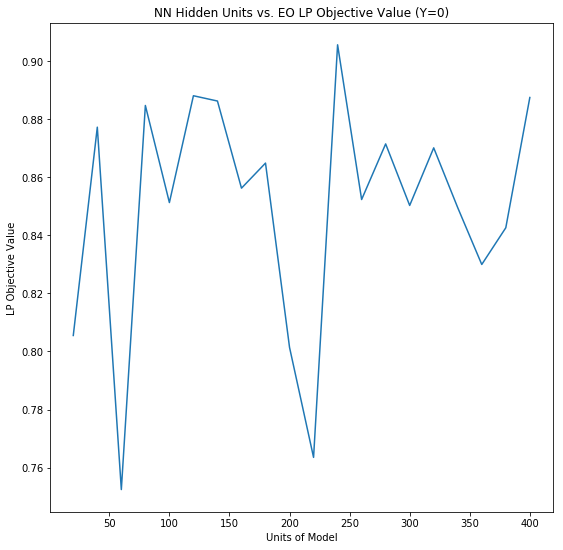

In [0]:
# Plot objective values
y0_objectives = []
for i in range(len(y0_models)):
  y0_objectives.append(pulp.value(y0_models[i].objective))
  
# Get values for x axis
x_axis = []
units = 20
for i in range(len(y0_models)):
  x_axis.append(units)
  units += 20

plt.figure(figsize=(9,9))
plt.plot(x_axis, y0_objectives)
plt.xlabel('Units of Model')
plt.ylabel('LP Objective Value')
plt.title('NN Hidden Units vs. EO LP Objective Value (Y=0)')

Text(0.5, 1.0, 'NN Hidden Units vs. Model Test Accuracy')

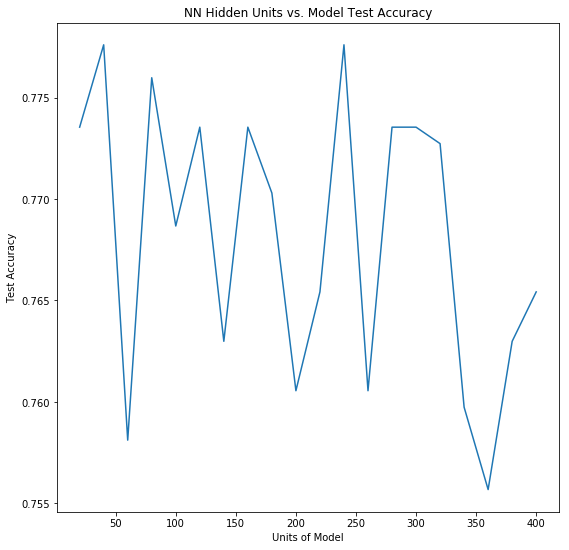

In [0]:
# Plot training accuracies over units
unit_model_accuracies_df = pd.read_csv('/content/drive/My Drive/colab/fairness_checking/unit_models/unit_model_accuracies.csv')
unit_model_accuracies_df.head(5)
unit_model_acc = unit_model_accuracies_df['Model Accuracy']

plt.figure(figsize=(9,9))
plt.plot(x_axis, unit_model_acc)
# plt.axis([0, 100, 0.8, 1.0])
plt.xlabel('Units of Model')
plt.ylabel('Test Accuracy')
plt.title('NN Hidden Units vs. Model Test Accuracy')

## Solve Linear Programs (Y = 1)
We use the PuLP package to solve the linear program for each of the f(X), where Y = 1.

In [0]:
# Solve for each of the f(X)
y1_models = []
y1_weights = []

for i in range(len(f_X)):
  model, weights = EO_linear_prog(f_X[i], 1)
  y1_models.append(model)
  y1_weights.append(weights)

In [0]:
# Get all the objective values
for i in range(len(f_X)):
  result_string = "Objective for f(X)_{} where Y = 1: ".format(i)
  print(result_string + str(pulp.value(y1_models[i].objective)))

Objective for f(X)_0 where Y = 1: 0.8745984333023437
Objective for f(X)_1 where Y = 1: 0.9090915529380682
Objective for f(X)_2 where Y = 1: 0.9019893430125403
Objective for f(X)_3 where Y = 1: 0.8982163580812192
Objective for f(X)_4 where Y = 1: 0.9025216080264852
Objective for f(X)_5 where Y = 1: 0.9121331229210566
Objective for f(X)_6 where Y = 1: 0.9173371028517293
Objective for f(X)_7 where Y = 1: 0.8364067338299592
Objective for f(X)_8 where Y = 1: 0.8945856271077871
Objective for f(X)_9 where Y = 1: 0.9308202006510553
Objective for f(X)_10 where Y = 1: 0.8680285533771948
Objective for f(X)_11 where Y = 1: 0.8985374690740694
Objective for f(X)_12 where Y = 1: 0.9068181679625794
Objective for f(X)_13 where Y = 1: 0.9342245366264099
Objective for f(X)_14 where Y = 1: 0.9226081627811793
Objective for f(X)_15 where Y = 1: 0.8606353935433505
Objective for f(X)_16 where Y = 1: 0.9466961274791029
Objective for f(X)_17 where Y = 1: 0.9118468828732895
Objective for f(X)_18 where Y = 1: 0.8

Text(0.5, 1.0, 'NN Hidden Units vs. EO LP Objective Value (Y=1)')

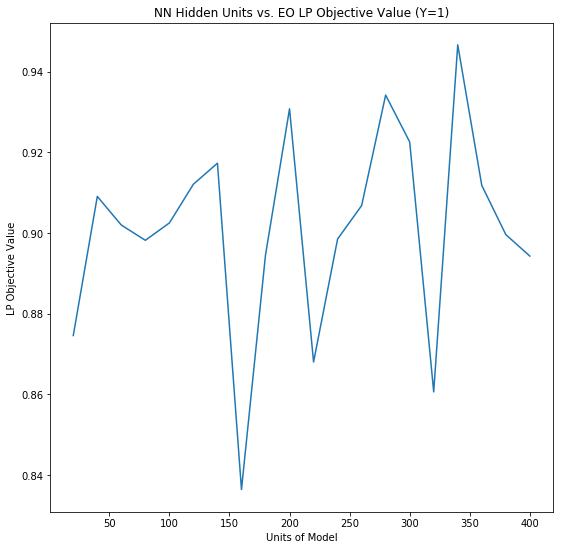

In [0]:
# Plot objective values
y1_objectives = []
for i in range(len(y1_models)):
  y1_objectives.append(pulp.value(y1_models[i].objective))

# Get values for x axis
x_axis = []
units = 20
for i in range(len(y1_models)):
  x_axis.append(units)
  units += 20

plt.figure(figsize=(9,9))
plt.plot(x_axis, y1_objectives)
plt.xlabel('Units of Model')
plt.ylabel('LP Objective Value')
plt.title('NN Hidden Units vs. EO LP Objective Value (Y=1)')

Text(0.5, 1.0, 'NN Hidden Units vs. Model Test Accuracy')

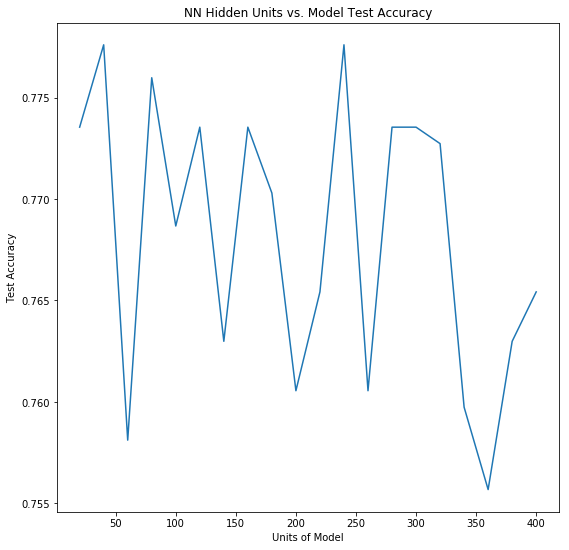

In [0]:
# Plot training accuracies over units
unit_model_accuracies_df = pd.read_csv('/content/drive/My Drive/colab/fairness_checking/unit_models/unit_model_accuracies.csv')
unit_model_accuracies_df.head(5)
unit_model_acc = unit_model_accuracies_df['Model Accuracy']

plt.figure(figsize=(9,9))
plt.plot(x_axis, unit_model_acc)
# plt.axis([0, 100, 0.8, 1.0])
plt.xlabel('Units of Model')
plt.ylabel('Test Accuracy')
plt.title('NN Hidden Units vs. Model Test Accuracy')

In [0]:
# Save as a CSV
df = pd.DataFrame({'Hidden Units':x_axis, 'EO LP Objective Values (Y=0)':y0_objectives, 'EO LP Objective Values (Y=1)':y1_objectives})
df.head(5)
df.to_csv('/content/drive/My Drive/colab/fairness_checking/eo_unit_models.csv')